Gan model


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Scale the transaction data
data = pd.read_csv('/content/Bitcoin History.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
numerical_features = data.select_dtypes(include=np.number).columns.tolist()
if 'Price' not in numerical_features:
    numerical_features.append('Price')

data_to_scale = data[numerical_features]
data_to_scale = data_to_scale.fillna(0)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_to_scale)  # Apply scaling to only numerical features
data_scaled = data_scaled.astype(np.float32)

In [3]:
# Define the Generator model
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)
input_dim = 10
output_dim = data_scaled.shape[1]
generator = Generator(input_dim, output_dim)
generated_data = generator(torch.randn(data_scaled.shape[0], input_dim)).detach().numpy()
reconstruction_error = np.mean((data_scaled - generated_data)**2, axis=1)
threshold = np.percentile(reconstruction_error, 95)

data['anomaly'] = reconstruction_error > threshold
anomalies = data[data['anomaly'] == True]
print("Detected Anomalies using GAN:", anomalies)

Detected Anomalies using GAN:            Date  Price     Open     High    Low     Vol. Change %  anomaly
2511 2017-03-26  969.4    966.3  1,004.3  946.7   85.33K    0.32%     True
2512 2017-03-25  966.3    939.7    996.0  890.4  127.05K    2.83%     True
2513 2017-03-24  939.7  1,035.0  1,038.4  927.3  132.60K   -9.21%     True
2519 2017-03-18  971.4  1,071.7  1,103.6  940.2  210.42K   -9.36%     True
2552 2017-02-13  995.4    996.5  1,007.6  975.1   32.91K   -0.12%     True
...         ...    ...      ...      ...    ...      ...      ...      ...
3731 2013-11-22  802.0    764.9    822.0  682.3   30.15K    4.85%     True
3732 2013-11-21  764.9    638.0    784.3  595.2   38.73K   19.90%     True
3733 2013-11-20  638.0    645.7    650.0  453.3   91.59K   -1.20%     True
3734 2013-11-19  645.7    785.4    900.9  502.6   99.10K  -17.79%     True
3735 2013-11-18  785.4    528.3    787.9  522.0   72.07K   48.67%     True

[248 rows x 8 columns]


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

data = pd.read_csv('/content/Bitcoin History.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

numerical_features = data.select_dtypes(include=np.number).columns.tolist()
if 'Price' not in numerical_features:
    numerical_features.append('Price')

data_to_scale = data[numerical_features]
data_to_scale = data_to_scale.fillna(0)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_to_scale)
data_scaled = data_scaled.astype(np.float32)
X = data_scaled[:, :-1]
y = data_scaled[:, -1]   #
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).view(-1, 1)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).view(-1, 1)

# Training the model
epochs = 100
for epoch in range(epochs):
    model.train()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()

# Evaluate the model using different metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch [0/100], Loss: 0.0641
Epoch [10/100], Loss: 0.0608
Epoch [20/100], Loss: 0.0591
Epoch [30/100], Loss: 0.0586
Epoch [40/100], Loss: 0.0585
Epoch [50/100], Loss: 0.0586
Epoch [60/100], Loss: 0.0585
Epoch [70/100], Loss: 0.0585
Epoch [80/100], Loss: 0.0585
Epoch [90/100], Loss: 0.0585
Mean Squared Error: 0.0196
Mean Absolute Error: 0.1393
R2 Score: -117.3757


Confusion Matrix:
 [[  0 503]
 [  0 488]]
Accuracy: 0.4924318869828456
Recall: 1.0
Precision: 0.4924318869828456
F1 Score: 0.6599053414469236


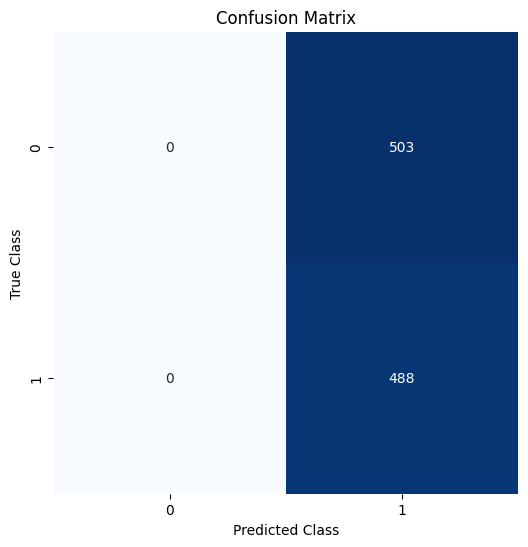

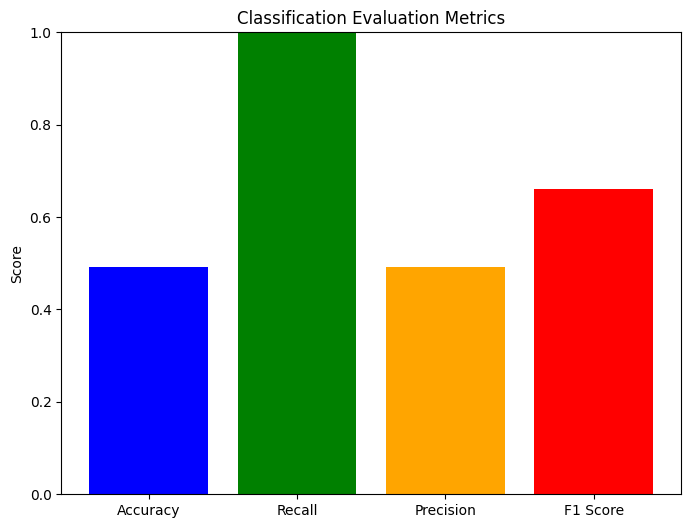

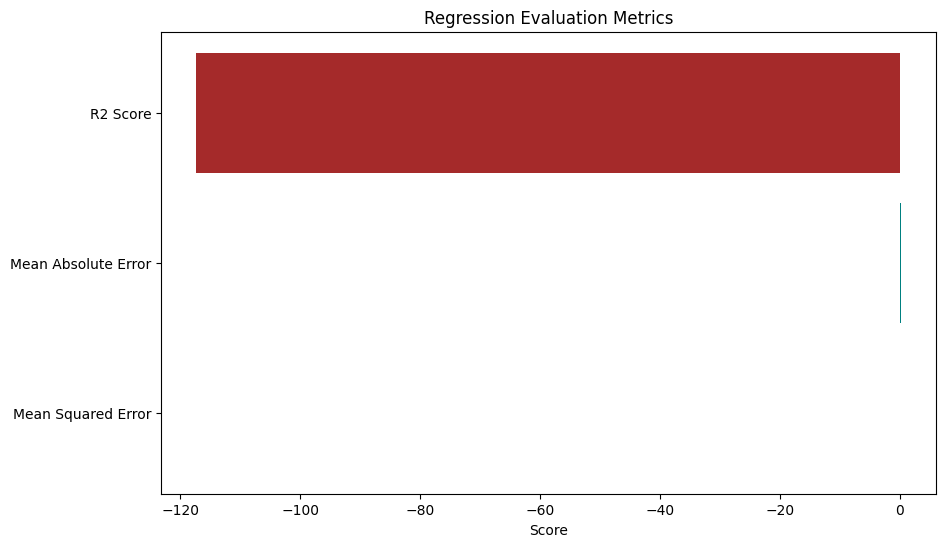

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
threshold = np.median(y_test)
y_test_class = (y_test > threshold).astype(int)
predictions_class = (predictions.flatten() > threshold).astype(int)

cm = confusion_matrix(y_test_class, predictions_class)
accuracy = accuracy_score(y_test_class, predictions_class)
recall = recall_score(y_test_class, predictions_class)
precision = precision_score(y_test_class, predictions_class)
f1 = f1_score(y_test_class, predictions_class)

print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

# Plot evaluation metrics
metrics = [accuracy, recall, precision, f1]
labels = ["Accuracy", "Recall", "Precision", "F1 Score"]
plt.figure(figsize=(8, 6))
plt.bar(labels, metrics, color=['blue', 'green', 'orange', 'red'])
plt.title("Classification Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

# Plot regression evaluation metrics
plt.figure(figsize=(10, 6))
regression_metrics = [mse, mae, r2]
regression_labels = ["Mean Squared Error", "Mean Absolute Error", "R2 Score"]
plt.barh(regression_labels, regression_metrics, color=['purple', 'teal', 'brown'])
plt.title("Regression Evaluation Metrics")
plt.xlabel("Score")
plt.show()
